In [ ]:
# Analizar data/processed para validar el corpus y orientar features.
# Entradas: sentences.jsonl por nivel y split.
# Salidas: tablas CSV y figuras en reports/.

#### ***Imports y config***

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 120)
SEED = 42

#### ***Rutas***

In [2]:
def find_root():
    p = Path.cwd()
    for cand in [p, *p.parents]:
        if (cand / "data" / "processed").exists():
            return cand
    raise FileNotFoundError("No encuentro data/processed.")

ROOT = find_root()
PROC = ROOT / "data" / "processed"
REPORTS = ROOT / "reports"
REPORTS.mkdir(parents=True, exist_ok=True)

NIVELES = ["easy","medium","hard"]
SPLITS = ["train","validation"]

#### ***Carga de processed***

In [3]:
dfs = []
for level in NIVELES:
    for split in SPLITS:
        p = PROC / level / split / "sentences.jsonl"
        if not p.exists():
            continue
        df = pd.read_json(p, lines=True)
        df["level"] = level
        df["split"] = split
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df["n_tokens"] = df["n_tokens"].astype(int)
df["sent_id"] = df["sent_id"].astype(int)
df["is_boundary"] = df["is_boundary"].astype(bool)
display(df.head())
print("Frases cargadas:", len(df))

,doc_id,sent_id,level,split,text_norm,n_tokens,is_boundary
0,problem-1734,0,easy,train,i learned this about ukraine a while back and i think it was mila kunis who said it and i knew about it since,24,False
1,problem-1734,1,easy,train,it s easy for some to make the mistake as back then i had no idea either,17,False
2,problem-1734,2,easy,train,but when ppl see others say it the respectfully correct them,11,False
3,problem-1734,3,easy,train,it s an offensive way to refer to ukraine and is an old soviet term and minimizes the legitimacy of them being a fre...,30,False
4,problem-1734,4,easy,train,similar to how ppl correct others when they use the russian soviet spelling of kyiv and say kiev,18,False


Frases cargadas: 208160


#### ***Métricas base***

In [4]:
res_base = (
    df.groupby(["level","split"]).agg(
        n_frases=("sent_id","count"),
        med_tokens_frase=("n_tokens","median"),
        p25_tokens=("n_tokens", lambda s: s.quantile(0.25)),
        p75_tokens=("n_tokens", lambda s: s.quantile(0.75)),
    ).reset_index()
)
display(res_base)
res_base.to_csv(REPORTS / "05_base_por_nivel_split.csv", index=False)

,level,split,n_frases,med_tokens_frase,p25_tokens,p75_tokens
0,easy,train,52701,13.0,7.0,23.0
1,easy,validation,11146,13.0,8.0,23.0
2,hard,train,55515,17.0,10.0,26.0
3,hard,validation,11649,18.0,10.0,26.0
4,medium,train,63386,16.0,9.0,26.0
5,medium,validation,13763,16.0,9.0,26.0


#### ***Métricas por documento***

In [5]:
por_doc = (
    df.groupby(["level","split","doc_id"]).agg(
        n_frases=("sent_id","count"),
        tokens_doc=("n_tokens","sum"),
        med_tokens_frase=("n_tokens","median"),
    ).reset_index()
)
display(por_doc.head())
por_doc.to_csv(REPORTS / "05_por_documento.csv", index=False)

res_doc = (
    por_doc.groupby(["level","split"]).agg(
        med_frases_doc=("n_frases","median"),
        p25_frases_doc=("n_frases", lambda s: s.quantile(0.25)),
        p75_frases_doc=("n_frases", lambda s: s.quantile(0.75)),
        med_tokens_doc=("tokens_doc","median"),
    ).reset_index()
)
display(res_doc)
res_doc.to_csv(REPORTS / "05_resumen_por_documento.csv", index=False)

,level,split,doc_id,n_frases,tokens_doc,med_tokens_frase
0,easy,train,problem-1,18,309,15.5
1,easy,train,problem-10,13,169,9.0
2,easy,train,problem-100,7,209,25.0
3,easy,train,problem-1000,18,282,12.0
4,easy,train,problem-1001,17,302,15.0


,level,split,med_frases_doc,p25_frases_doc,p75_frases_doc,med_tokens_doc
0,easy,train,12.0,10.0,15.00,202.0
1,easy,validation,12.0,10.0,14.00,202.0
2,hard,train,12.0,10.0,16.00,232.0
3,hard,validation,12.0,10.0,15.00,231.0
4,medium,train,13.0,10.0,16.00,216.0
5,medium,validation,13.0,10.0,16.25,216.0


#### ***Fronteras***

In [6]:
tiene_fronteras = bool(df["is_boundary"].any())
print("Hay fronteras anotadas:", tiene_fronteras)

if tiene_fronteras:
    por_doc_b = (
        df.groupby(["level","split","doc_id"]).agg(
            n_fr=("sent_id","count"),
            n_b=("is_boundary","sum"),
        ).reset_index()
    )
    por_doc_b["densidad_frontera"] = por_doc_b["n_b"] / por_doc_b["n_fr"].replace(0, np.nan)
    res_b = por_doc_b.groupby(["level","split"]).agg(
        med_dens=("densidad_frontera","median")
    ).reset_index()
    display(res_b)
    por_doc_b.to_csv(REPORTS / "05_fronteras_por_documento.csv", index=False)
    res_b.to_csv(REPORTS / "05_fronteras_resumen.csv", index=False)

Hay fronteras anotadas: False


EXPLICACION

#### ***Plots***

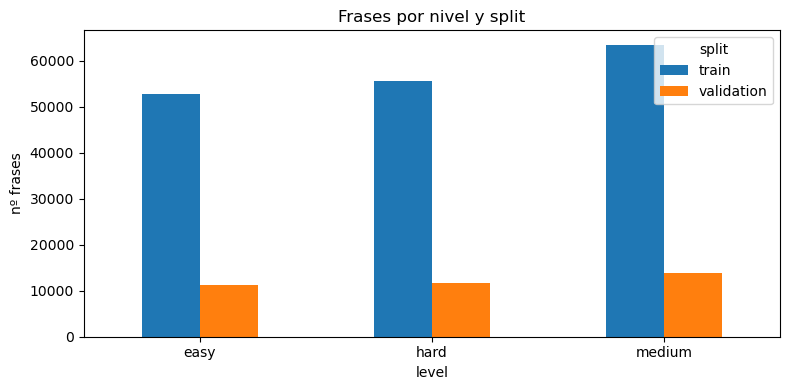

<Figure size 800x400 with 0 Axes>

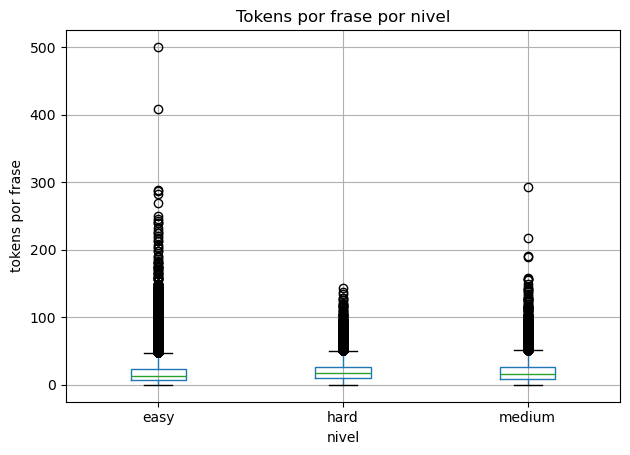

<Figure size 800x400 with 0 Axes>

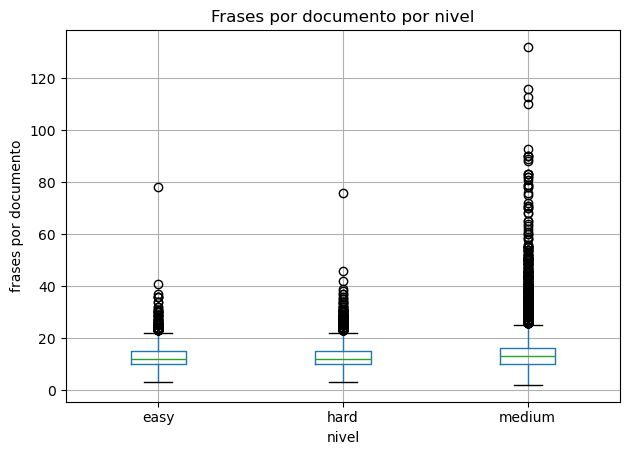

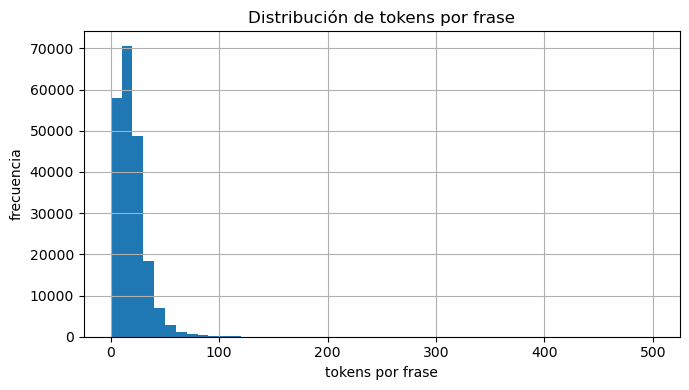

In [7]:
# 8.1 Frases por nivel y split
cnt = df.groupby(["level","split"])["sent_id"].count().reset_index(name="n_frases")
pv = cnt.pivot(index="level", columns="split", values="n_frases").fillna(0)
ax = pv.plot(kind="bar", rot=0, figsize=(8,4))
ax.set_ylabel("nº frases")
ax.set_title("Frases por nivel y split")
plt.tight_layout()
plt.savefig(REPORTS / "05_frases_por_nivel_split.png", dpi=150)
plt.show()

# 8.2 Boxplot tokens por frase
plt.figure(figsize=(8,4))
df.boxplot(column="n_tokens", by="level")
plt.suptitle("")
plt.title("Tokens por frase por nivel")
plt.xlabel("nivel")
plt.ylabel("tokens por frase")
plt.tight_layout()
plt.savefig(REPORTS / "05_box_tokens_por_frase.png", dpi=150)
plt.show()

# 8.3 Boxplot frases por documento
plt.figure(figsize=(8,4))
por_doc.boxplot(column="n_frases", by="level")
plt.suptitle("")
plt.title("Frases por documento por nivel")
plt.xlabel("nivel")
plt.ylabel("frases por documento")
plt.tight_layout()
plt.savefig(REPORTS / "05_box_frases_por_documento.png", dpi=150)
plt.show()

# 8.4 Histograma tokens por frase
plt.figure(figsize=(7,4))
df["n_tokens"].hist(bins=50)
plt.xlabel("tokens por frase")
plt.ylabel("frecuencia")
plt.title("Distribución de tokens por frase")
plt.tight_layout()
plt.savefig(REPORTS / "05_hist_tokens_por_frase.png", dpi=150)
plt.show()

# 8.5 Densidad de fronteras si aplica
if tiene_fronteras:
    plt.figure(figsize=(7,4))
    por_doc_b["densidad_frontera"].dropna().hist(bins=40)
    plt.xlabel("fronteras / frases")
    plt.ylabel("frecuencia")
    plt.title("Densidad de fronteras por documento")
    plt.tight_layout()
    plt.savefig(REPORTS / "05_hist_densidad_fronteras.png", dpi=150)
    plt.show()